In [29]:
%matplotlib ipympl
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
from impedance.visualization import plot_nyquist, plot_bode
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import pandas as pd
from scipy import stats

In [30]:
#My written functions
def add_noise(z,err):
    #err is the relative SD from mean value
    z_with_noise=np.random.normal(np.real(z),err*np.abs(np.real(z)))+1j*np.random.normal(np.imag(z),err*np.abs(np.imag(z)))
    return z_with_noise

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))
    
def give_xylim(zin,z0):
        zin_real=np.real(zin)
        zin_imag=np.imag(zin)

        z0_real=np.real(z0)
        z0_imag=np.imag(z0)

        max_0=np.maximum(np.max(z0_real),np.max(-z0_imag))
        max_in=np.maximum(np.max(zin_real),np.max(-zin_imag))

        xylim=np.maximum(max_0,max_in)
        return xylim

def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [31]:
@element(num_params=5, units=["Ohm", "Ohm", "","F",""],overwrite=True)
def TLMtwoNew(p, f):
   
    omega = 2 * np.pi * np.array(f)
    R1, R2, delta1, Q, alpha = p[0], p[1], p[2], p[3], p[4]
    delta2=1-delta1
    k12=R2/R1
    CTotal1=Q
    CTotal2=Q
    wc1=1/(R1*CTotal1)
    wc2=1/(R2*CTotal2)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)

    Z=2*(R1)*(C1*C2*S1*k12+S2)/(S1*(C2*S1*k12+C1*S2))

    return Z

# @element(num_params=2, units=["Ohm", ""],overwrite=True)
# def lin(p,f):
#     omega = 2 * np.pi * np.array(f)
#     c,m = p[0], p[1]
#     Z=1/omega+1j*(m*(1/omega-c))
#     return Z

In [32]:
#Old Plotter And Saver
# def plotter_and_saver(fitted_pm,pm_conf,input_pm,z_with_noise,freq,save_folder_name):
  
#     R1_fit=fitted_pm[0]
#     R2_fit=fitted_pm[1]
#     delta_fit=fitted_pm[2]
#     Q_fit=fitted_pm[3]
#     alpha_fit=fitted_pm[4]

#     R1_in=input_pm[0]
#     R2_in=input_pm[1]
#     delta_in=input_pm[2]
#     Q_in=input_pm[3]
#     alpha_in=input_pm[4]

#     circuit_in=CustomCircuit(initial_guess=[R1_in,R2_in,Q_in,delta_in],circuit='TLMtwoNew_0')
#     z_in_as_per_pm=circuit_in.predict(freq)

#     z_with_noise=z_with_noise          #final input data with noise

#     circuit_fit=CustomCircuit(initial_guess=[R1_fit,R2_fit,Q_fit,delta_fit],circuit='TLMtwoNew_0')
#     z_fit=circuit_fit.predict(freq)

#     linewidth=1
#     ticksize=6
#     color_actual="green"
#     color_noise="red"
#     color_fitted="blue"

#     fig = plt.figure(f"Results at δ={delta_in}")
#     fig.set_size_inches(10,6)
    
#     ax1= fig.add_subplot(2,3,2)

#     ax1.plot([0,delta_in,delta_in,1],[R1_in,R1_in,R2_in,R2_in],linewidth=linewidth,color=color_actual,label="Actual")
#     ax1.plot([0,delta_fit,delta_fit,1],[R1_fit,R1_fit,R2_fit,R2_fit],linewidth=linewidth,color=color_fitted,label="Fitted")
#     ax1.tick_params(labelsize=ticksize)
#     ax1.axvline(x=delta_in,ls="--",linewidth=0.6,color=color_actual)
#     ax1.axvline(x=delta_fit,ls="--",linewidth=0.6,color=color_fitted)

#     ax1.set_ylabel("R1 / R2 (Ω)")
#     ax1.set_xlabel("δ")
#     ax1.set_xmargin(0)
#     ax1.legend()

#     ax2=fig.add_subplot(2,3,3)
#     z_with_noise_real=np.real(z_with_noise)
#     z_with_noise_imag=np.imag(z_with_noise)

#     z_in_real=np.real(z_in_as_per_pm)
#     z_in_imag=np.imag(z_in_as_per_pm)

#     z_fit_real=np.real(z_fit)
#     z_fit_imag=np.imag(z_fit)

#     max_in=np.maximum(np.max(z_in_real),np.max(-z_in_imag))
#     max_with_noise=np.maximum(np.max(z_with_noise_real),np.max(-z_with_noise_imag))
#     max_fit=np.maximum(np.max(z_fit_real),np.max(-z_fit_imag))
    
#     x_y_lim=np.maximum(max_in,max_fit)

#     ax2.set_xlim(-0.2*x_y_lim/1000,x_y_lim/1000)
#     ax2.set_ylim(-0.2*x_y_lim/1000,x_y_lim/1000)

#     #ax2.set_xlim(0,0.2)
#     #ax2.set_ylim(0,0.2)

#     plot_nyquist(z_in_as_per_pm/1000,ax=ax2,units="kΩ",labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
#     plot_nyquist(z_with_noise/1000,ax=ax2,units="kΩ",labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
#     plot_nyquist(z_fit/1000,ax=ax2,units="kΩ",labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)

#     ax2_inset=ax2.inset_axes(bounds=[0.4,0.4,0.5,0.5])
#     plot_nyquist(z_in_as_per_pm/1000,ax=ax2_inset,units="kΩ",labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
#     plot_nyquist(z_with_noise/1000,ax=ax2_inset,units="kΩ",labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
#     plot_nyquist(z_fit/1000,ax=ax2_inset,units="kΩ",labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)
#     ax2_inset.set_xlim(0,np.maximum(np.max(z_in_real),np.max(z_fit_real))/1000)
#     ax2_inset.set_ylim(0,np.maximum(np.max(z_in_real),np.max(z_fit_real))/1000)
#     ax2_inset.set_xlabel("")
#     ax2_inset.set_ylabel("")

#     ax2.indicate_inset_zoom(ax2_inset)

#     ax3a=fig.add_subplot(2,3,5)
#     ax3b=fig.add_subplot(2,3,6)
#     #ax3.set_xlim(0,1)
#     #ax3.set_ylim(0,1)
#     plot_bode(freq,z_in_as_per_pm/1000,axes=[ax3a,ax3b],units="kΩ",labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
#     plot_bode(freq,z_with_noise/1000,axes=[ax3a,ax3b],units="kΩ",labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
#     plot_bode(freq,z_fit/1000,axes=[ax3a,ax3b],units="kΩ",labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)

#     fitted_pm[0]=np.around(fitted_pm[0],decimals=0,out=None)
#     fitted_pm[1]=np.around(fitted_pm[1],decimals=0,out=None)
#     fitted_pm[2]=np.around(fitted_pm[2],decimals=6,out=None)
#     fitted_pm[3]=np.around(fitted_pm[3],decimals=4,out=None)

#     pm_conf[0]=np.around(pm_conf[0],decimals=0,out=None)
#     pm_conf[1]=np.around(pm_conf[1],decimals=0,out=None)
#     pm_conf[2]=np.around(pm_conf[2],decimals=6,out=None)
#     pm_conf[3]=np.around(pm_conf[3],decimals=4,out=None)


#     data =np.array([input_pm,
#             fitted_pm, (input_pm-fitted_pm)*100/(input_pm)])
#     #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    
#     ax4=fig.add_subplot(1,3,1)
#     ax4.set_axis_off()
#     pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted","% Error"],rowLabels=["R1","R2","Q","δ"],loc="center")
#     pm_table.auto_set_font_size(False)
#     pm_table.set_fontsize(10)

#     plt.savefig(save_folder_name+f"//δ={delta_in}.png",format="png")
#     #plt.show()
#     plt.close()
# 
#freq = np.logspace(3,-3,num=100)

# R1_R2_in_list=((1000,100),(502,500))
# delta_to_be_tested=[0.01,0.1,0.2,0.5,0.8,0.9,0.99]
# #delta_to_be_tested=[0.2]
# Q_in=6.61e-4
# noise=True

# ### intially guessed values of parameters for the model ### 
# R1_gs=300
# R2_gs=300
# delta_gs=0.5
# Q_gs=Q_in

# ### creating a circuit object for the initial guess model (for which parameters are just above defined) ###
# circuit_guess=CustomCircuit(initial_guess=[R1_gs,R2_gs,Q_gs,delta_gs],circuit='TLMtwoNew_0')

# for R1_R2 in R1_R2_in_list:

#     R1_in=R1_R2[0]
#     R2_in=R1_R2[1]
    
#     name_of_folder_to_save_data=f"R1={R1_in} R2={R2_in} Q={Q_in} and diff delta"

#     if os.path.exists(name_of_folder_to_save_data):
#         shutil.rmtree(name_of_folder_to_save_data)
#     os.mkdir(f"{name_of_folder_to_save_data}")

#     for delta_in in delta_to_be_tested:
#         circuit_in=CustomCircuit(initial_guess=[R1_in,R2_in,Q_in,delta_in],circuit='TLMtwoNew_0')
#         pm_input=[R1_in,R2_in,Q_in,delta_in]
#         z_from_circuit_in = circuit_in.predict(freq)
#         if noise:
#             for i in range(len(z_from_circuit_in)):
#                 z_real_new=np.random.normal(np.real(z_from_circuit_in[i]),np.abs(0.05*np.real(z_from_circuit_in[i])))
#                 z_imag_new=np.random.normal(np.imag(z_from_circuit_in[i]),np.abs(0.05*np.imag(z_from_circuit_in[i])))
#                 z_from_circuit_in[i]=z_real_new+1j*z_imag_new
                
#         circuit_fitted=circuit_guess.fit(freq,z_from_circuit_in,bounds=(0,[np.inf,np.inf,np.inf,1]))
#         pm_fitted=circuit_fitted.parameters_
#         pm_conf=circuit_fitted.conf_
#         plotter_and_saver(pm_fitted,pm_conf,pm_input,z_from_circuit_in,freq,name_of_folder_to_save_data)

In [33]:
freq = np.logspace(3,-3,num=100)
c0=CustomCircuit(initial_guess=[1000,500,0.5,1e-4,1],circuit='TLMtwoNew')
z0=c0.predict(freq)
z1=add_noise(z0,0.05)
z2=add_noise(z0,0.05)
z3=add_noise(z0,0.05)
p0=c0.initial_guess
R1_0=p0[0]
R2_0=p0[1]
delta_0=p0[2]
Q_0=p0[3]
alpha_0=p0[4]
# x,ax=plt.subplots()
# plot_nyquist(z0,ax=ax)
# ax.set_xlim(0,2000)
# ax.set_ylim(0,2000)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


In [34]:
# f_c=1/(R1_0*Q_0)
# idx=find_index_of_nearest(freq,f_c)
# print(idx)
idx=int(len(freq)/2)
print(idx)
z1_for_cpe=z1[idx:len(freq)-1]
cgcpe1=CustomCircuit(initial_guess=[1e-4,0.95],circuit="CPE")
cgcpe1.fit(freq[idx:len(freq)-1],z1_for_cpe)
p_gs1=cgcpe1.parameters_
Q_gs1=p_gs1[0]
alpha_gs1=p_gs1[1]
print(Q_gs1,alpha_gs1)

z2_for_cpe=z2[idx:len(freq)-1]
cgcpe2=CustomCircuit(initial_guess=[1e-4,0.95],circuit="CPE")
cgcpe2.fit(freq[idx:len(freq)-1],z2_for_cpe)
p_gs2=cgcpe2.parameters_
Q_gs2=p_gs2[0]
alpha_gs2=p_gs2[1]
print(Q_gs2,alpha_gs2)

z3_for_cpe=z3[idx:len(freq)-1]
cgcpe3=CustomCircuit(initial_guess=[1e-4,0.95],circuit="CPE")
cgcpe3.fit(freq[idx:len(freq)-1],z3_for_cpe)
p_gs3=cgcpe1.parameters_
Q_gs3=p_gs3[0]
alpha_gs3=p_gs3[1]
print(Q_gs3,alpha_gs3)


# cglin=CustomCircuit(initial_guess=[1000,1],circuit="lin")
# cglin.fit(freq[idx:len(freq)-1],z1[idx:len(freq)-1])
# plin_gs=cglin.parameters_
# print(plin_gs)



param_guess1=[1000,500,0.5,Q_gs1,alpha_gs1]
param_guess2=[1000,500,0.5,Q_gs2,alpha_gs2]
param_guess3=[1000,500,0.5,Q_gs3,alpha_gs3]
cg1=CustomCircuit(initial_guess=param_guess1,circuit="TLMtwoNew")
cg2=CustomCircuit(initial_guess=param_guess2,circuit="TLMtwoNew")
cg3=CustomCircuit(initial_guess=param_guess3,circuit="TLMtwoNew")


50
4.894571422551423e-05 0.999999999999772
4.985720935187743e-05 0.9958327747478647
4.894571422551423e-05 0.999999999999772


In [35]:
def plotter_for_two(freq,circuit0,zin1,zin2,zin3,circuitg1,circuitg2,circuitg3,wt):
    
    c0=circuit0
    z0=c0.predict(freq)
    cg1=circuitg1
    cg2=circuitg2
    cg3=circuitg3
    cf1=cg1.fit(freq,zin1,sigma=give_weights(zin1,wt),bounds=(0,[np.inf,np.inf,1,np.inf,1]))
    #print(cf1)
    cf2=cg2.fit(freq,zin2,sigma=give_weights(zin2,wt),bounds=(0,[np.inf,np.inf,1,np.inf,1]))
    cf3=cg3.fit(freq,zin3,sigma=give_weights(zin3,wt),bounds=(0,[np.inf,np.inf,1,np.inf,1]))
    #print(cg3)

    zf1=cf1.predict(freq)
    zf2=cf2.predict(freq)
    zf3=cf3.predict(freq)

    p0=c0.initial_guess
    R1_0=p0[0]
    R2_0=p0[1]
    delta_0=p0[2]
    Q_0=p0[3]
    alpha_0=p0[4]

    pg=cg1.initial_guess
    R1_g=pg[0]
    R2_g=pg[1]
    delta_g=pg[2]
    Q_g=pg[3]
    alpha_g=pg[4]   

    pf1=cg1.parameters_
    print("pf1",pf1)
    R1_f1=pf1[0]
    R2_f1=pf1[1]
    delta_f1=pf1[2]
    Q_f1=pf1[3]
    alpha_f1=pf1[4]


    pf2=cg2.parameters_
    print("pf2",pf2)
    R1_f2=pf2[0]
    R2_f2=pf2[1]
    delta_f2=pf2[2]
    Q_f2=pf2[3]
    alpha_f2=pf2[4]

    pf3=cf3.parameters_
    R1_f3=pf3[0]
    R2_f3=pf3[1]
    delta_f3=pf3[2]
    Q_f3=pf3[3]
    alpha_f3=pf3[4]

    linewidth=1
    linewidth_actual=3
    ticksize=6
    color_actual="red"
    color_noise1=[0,0.5,0]
    color_noise2=[0.2,0.4,0.2]
    color_noise3=[0,0.65,0.4]
    color_fitted1=[0,0,1]
    color_fitted2=[0.4,0.58,0.65]
    color_fitted3=[0,0.6,1]

    fig = plt.figure(f"Results at δ={delta_0}")
    fig.set_size_inches(10,6)
    
    #profile fit and profile original
    ax1=plt.subplot2grid((5,4),(1,0),rowspan=2,colspan=2)
    #ax1= fig.add_subplot(2,4,1)
    ax1.plot([0,delta_0,delta_0,1],[R1_0,R1_0,R2_0,R2_0],linewidth=linewidth_actual,color=color_actual,label="Actual")
    ax1.plot([0,delta_f1,delta_f1,1],[R1_f1,R1_f1,R2_f1,R2_f1],linewidth=linewidth,color=color_fitted1,label="Fitted 1")
    ax1.plot([0,delta_f2,delta_f2,1],[R1_f2,R1_f2,R2_f2,R2_f2],linewidth=linewidth,color=color_fitted2,label="Fitted 2")
    ax1.plot([0,delta_f3,delta_f3,1],[R1_f3,R1_f3,R2_f3,R2_f3],linewidth=linewidth,color=color_fitted3,label="Fitted 3")
    ax1.tick_params(labelsize=ticksize)
    ax1.axvline(x=delta_0,ls="--",linewidth=0.6,color=color_actual)
    ax1.axvline(x=delta_f1,ls="--",linewidth=0.6,color=color_fitted1)
    ax1.axvline(x=delta_f2,ls="--",linewidth=0.6,color=color_fitted2)
    ax1.axvline(x=delta_f3,ls="--",linewidth=0.6,color=color_fitted3)
    ax1.set_ylabel("R1 / R2 (Ω)")
    ax1.set_xlabel("δ")
    ax1.set_xmargin(0)
    leg=ax1.legend()
    for line in leg.get_lines():
        line.set_linewidth(3)

    xylim=max(give_xylim(zin1,zf1),give_xylim(zin1,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    #nyquist plot 
    #ax2=fig.add_subplot(1,2,2)
    ax2=plt.subplot2grid((5,4),(1,2),colspan=2,rowspan=4)
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(zin1/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf2/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf3/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    #inset_for_nyquist_plot
    ax2_inset=ax2.inset_axes(bounds=[0.4,0.1,0.5,0.5])
    plot_nyquist(zin1/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf3/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(R1_0*Q_0)
    idx=find_index_of_nearest(freq,f_c)
    z_c=c0.predict([freq[idx]])

    xylim_inset=1.2*np.real(z_c)
    ax2_inset.set_xlim(0,xylim_inset/factor)
    ax2_inset.set_ylim(0,xylim_inset/factor)
    ax2_inset.set_xlabel("")
    ax2_inset.set_ylabel("")
    ax2.indicate_inset_zoom(ax2_inset)

    ax2_inset1=ax2.inset_axes(bounds=[0.4,0.7,0.3,0.2])
    plot_nyquist(zin1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(1000*R1_0*Q_0)

    f_c=freq[len(freq)-1]*2
    idx=find_index_of_nearest(freq,f_c)
    z0c=c0.predict([freq[idx]])
    zfc1=cf1.predict([freq[idx]])
    zfc2=cf2.predict([freq[idx]])
    zfc3=cf3.predict([freq[idx]])
    
    max_xlim_inset=np.max([np.real(z0c),np.real(zfc1),np.real(zfc2),np.real(zfc3)])
    max_ylim_inset=np.max([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2),-np.imag(zfc3)])
    min_xlim_inset=np.min([np.real(z0c),np.real(zfc1),np.real(zfc2),np.real(zfc3)])
    min_ylim_inset=np.min([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2),-np.imag(zfc3)])
    gap=(max_xlim_inset-min_xlim_inset)/factor
    print(gap)
    # ax2_inset1.set_xlim(xlim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_ylim(ylim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_xlim(min_xlim_inset/factor-0.1*max_xlim_inset/factor,1.1*max_xlim_inset/factor)
    # ax2_inset1.set_ylim(min_ylim_inset/factor-0.1*max_xlim_inset/factor,min_ylim_inset/factor+0.1*max_xlim_inset/factor)
    
    ax2_inset1.set_xlim(min_xlim_inset/factor-2*gap,2*gap+max_xlim_inset/factor)
    ax2_inset1.set_ylim(min_ylim_inset/factor-2*gap,min_ylim_inset/factor+2*gap)
    ax2_inset1.set_aspect("equal")
    ax2_inset1.set_xlabel("")
    ax2_inset1.set_ylabel("")
    ax2_inset1.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2_inset1.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2.indicate_inset_zoom(ax2_inset1)

    #bode plots
    #ax3a=fig.add_subplot(2,4,5)
    #ax3b=fig.add_subplot(2,4,6)
    ax3a=plt.subplot2grid((5,4),(3,0),colspan=1,rowspan=2)
    ax3b=plt.subplot2grid((5,4),(3,1),colspan=1,rowspan=2)
    plot_bode(freq,zin1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_bode(freq,zin2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_bode(freq,zin3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_bode(freq,zf1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)


    percent_err1=(p0-pf1)*100/(p0)
    percent_err2=(p0-pf2)*100/(p0)
    percent_err3=(p0-pf3)*100/(p0)

    p0_table=[R1_0,R2_0,delta_0,Q_0,alpha_0]
    pf1_table=[R1_f1,R2_f1,delta_f1,Q_f1,alpha_f1]
    pf2_table=[R1_f2,R2_f2,delta_f2,Q_f2,alpha_f2]
    pf3_table=[R1_f3,R2_f3,delta_f3,Q_f3,alpha_f3]
    pg_table=[R1_g,R2_g,delta_g,Q_g,alpha_g]

    percent_err_table1=percent_err1
    percent_err_table2=percent_err2
    percent_err_table3=percent_err3

    def make_values_for_table(arr):
        for i in range(0,len(arr)):
            arr[i]="{:.2e}".format(arr[i])
        return arr
    
    pf1_table=make_values_for_table(pf1_table)
    pf2_table=make_values_for_table(pf2_table)
    pf3_table=make_values_for_table(pf3_table)
    p0_table=make_values_for_table(p0_table)
    pg_table=make_values_for_table(pg_table)
    percent_err_table1=make_values_for_table(percent_err_table1)
    percent_err_table2=make_values_for_table(percent_err_table2)
    percent_err_table3=make_values_for_table(percent_err_table3)

    data =np.array([p0_table,pg_table,pf1_table,percent_err_table1,pf2_table,percent_err_table2,pf3_table,percent_err_table3])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    
    ax4=plt.subplot2grid((5,4),(0,0),colspan=4,rowspan=1)
    ax4.set_axis_off()
    colwidth=np.full((8),0.1)
    pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Guess","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],colWidths=colwidth,rowLabels=["R1 [Ω]","R2 [Ω]","δ","Q [Fs^(1-α)]","α"],loc="center") 
    pm_table.auto_set_font_size(False)
    pm_table.set_fontsize(8)

    pm_table_df=pd.DataFrame(np.transpose(data),columns=["Actual","Guess","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],index=["R1 [Ω]","R2 [Ω]","δ","Q [Fs^(1-α)]","α"])

    with pd.ExcelWriter("gg.xlsx",mode="w",) as writer:
        pm_table_df.to_excel(writer)

    fig.tight_layout(pad=0.5)

 


In [51]:
plt.close()
xx=np.real(z1_for_cpe)
yy =-np.imag(z1_for_cpe)
# xx=np.linspace(1,6,6)
# yy=np.linspace(0,10,6)
# plt.plot(xx,yy)
# plt.
res=stats.linregress(yy,xx)
print(res)
plt.show()

LinregressResult(slope=3.1612380602666535e-06, intercept=628.5546763112216, rvalue=0.088655941814166, pvalue=0.544670429730737, stderr=5.180681962380128e-06, intercept_stderr=4.24482284949204)


pf1 [9.83729912e+02 3.00320799e+01 6.42097421e-01 1.01082707e-04
 9.99997758e-01]
pf2 [9.96885238e+02 7.27147024e+02 3.99741694e-01 1.00129180e-04
 1.00000000e+00]
0.007190456425301363


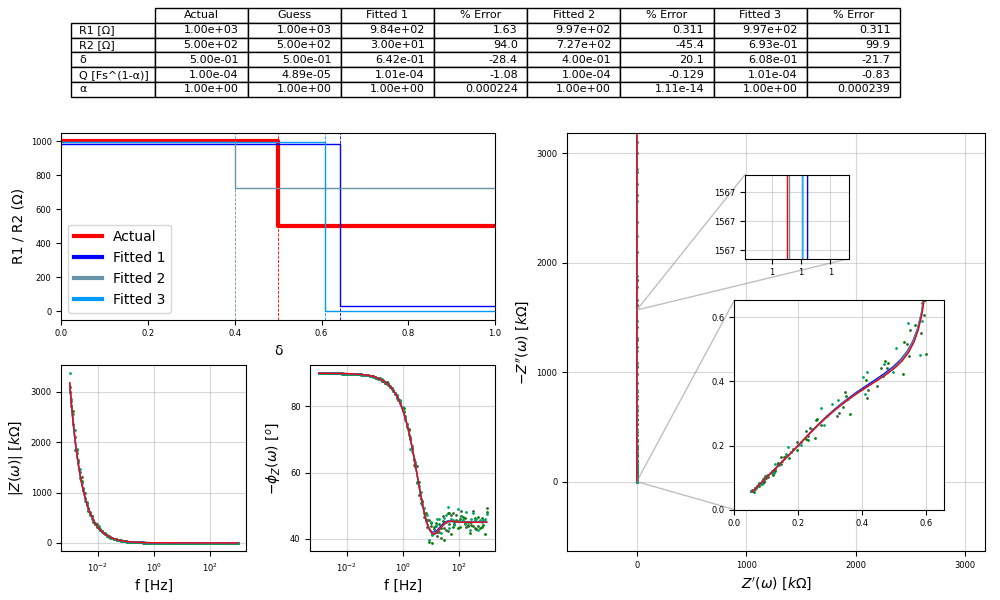

In [37]:
plt.close()
plotter_for_two(freq=freq,circuit0=c0,circuitg1=cg1,circuitg2=cg2,circuitg3=cg3,zin1=z1,zin2=z2,zin3=z3,wt="prop")
plt.show()

In [38]:
# def plotter_for_two(freq,circuit0,zin,circuitg,wt):
    
#     c0=circuit0
#     z0=c0.predict(freq)
    
#     cg=circuitg
#     cf=cg.fit(freq,zin,sigma=give_weights(zin,wt),bounds=(0,[np.inf,np.inf,np.inf,1]))
#     zf=cf.predict(freq)

#     p0=c0.initial_guess
#     R1_0=p0[0]
#     R2_0=p0[1]
#     Q_0=p0[2]
#     delta_0=p0[3]

#     pf=cf.parameters_
#     R1_f=pf[0]
#     R2_f=pf[1]
#     Q_f=pf[2]
#     delta_f=pf[3]

#     linewidth=1
#     ticksize=6
#     color_actual="green"
#     color_noise="red"
#     color_fitted="blue"

#     fig = plt.figure(f"Results at δ={delta_0}")
#     fig.set_size_inches(10,6)
    
#     #profile fit and profile original
#     ax1= fig.add_subplot(2,3,2)
#     ax1.plot([0,delta_0,delta_0,1],[R1_0,R1_0,R2_0,R2_0],linewidth=linewidth,color=color_actual,label="Actual")
#     ax1.plot([0,delta_f,delta_f,1],[R1_f,R1_f,R2_f,R2_f],linewidth=linewidth,color=color_fitted,label="Fitted")
#     ax1.tick_params(labelsize=ticksize)
#     ax1.axvline(x=delta_0,ls="--",linewidth=0.6,color=color_actual)
#     ax1.axvline(x=delta_f,ls="--",linewidth=0.6,color=color_fitted)
#     ax1.set_ylabel("R1 / R2 (Ω)")
#     ax1.set_xlabel("δ")
#     ax1.set_xmargin(0)
#     ax1.legend()

#     xylim=max(give_xylim(zin,zf),give_xylim(zin,z0))

#     if xylim%1000>=1:
#         units="kΩ"
#         factor=1000
#     else:
#         units="Ω"
#         factor=1

#     #nyquist plot 
#     ax2=fig.add_subplot(2,3,3)
#     ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
#     ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
#     plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
#     plot_nyquist(zin/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
#     plot_nyquist(zf/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)
#     #inset_for_nyquist_plot
#     ax2_inset=ax2.inset_axes(bounds=[0.4,0.4,0.5,0.5])
#     plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
#     plot_nyquist(zin/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
#     plot_nyquist(zf/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)    
#     xylim=give_xylim(np.real(z0),np.real(zf))
#     ax2_inset.set_xlim(0,xylim/factor)
#     ax2_inset.set_ylim(0,xylim/factor)
#     ax2_inset.set_xlabel("")
#     ax2_inset.set_ylabel("")
#     ax2.indicate_inset_zoom(ax2_inset)

#     #bode plots
#     ax3a=fig.add_subplot(2,3,5)
#     ax3b=fig.add_subplot(2,3,6)
#     plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
#     plot_bode(freq,zin/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise,ms=2,ticksize=ticksize)
#     plot_bode(freq,zf/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted,linewidth=linewidth,ticksize=ticksize)


#     pf[0]=np.around(pf[0],decimals=0,out=None)
#     pf[1]=np.around(pf[1],decimals=0,out=None)
#     pf[2]=np.around(pf[2],decimals=6,out=None)
#     pf[3]=np.around(pf[3],decimals=4,out=None)

#     p0[0]=np.around(p0[0],decimals=0,out=None)
#     p0[1]=np.around(p0[1],decimals=0,out=None)
#     p0[2]=np.around(p0[2],decimals=6,out=None)
#     p0[3]=np.around(p0[3],decimals=4,out=None)

#     data =np.array([p0,pf, (p0-pf)*100/(p0)])
#     #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    
#     ax4=fig.add_subplot(1,3,1)
#     ax4.set_axis_off()
#     pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted","% Error"],rowLabels=["R1","R2","Q","δ"],loc="center")
#     pm_table.auto_set_font_size(False)
#     pm_table.set_fontsize(10)

    